In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

## Stat data

In [2]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [3]:
stat_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:-1]]

In [4]:
for yi in range(len(stat_list)):
    y = files[yi].split('.')[0]
    c = stat_list[yi].columns
    c = [y+'-'+ci for ci in c]
    # c = [y[2:]+'-'+str(ci) for ci in range(len(c))]
    stat_list[yi].columns = c

## Poll data

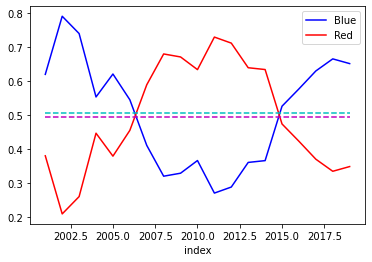

In [5]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/percent_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Voting data

In [6]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [7]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [8]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [9]:
vote_list[0] = vote_list[0].set_index('województwo')

In [10]:
if(False):
    for yi in range(len(vote_list)):
        y = files[yi].split('_WS')[0]
        c = vote_list[yi].columns
        #c = [y+'-'+ci for ci in c]
        # c = [y[2:]+'-'+str(ci) for ci in range(len(c))]
        vote_list[yi].columns = c

        #vote_list[yi] = vote_list[yi].div(vote_list[yi].sum(axis=1), axis=0).fillna(0)

## Neighbours

In [11]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Use 2 approaches to estimate date from years without elections

In [12]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0].iloc[:,:-1]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0].iloc[:,:-1]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
    
    par_in_reg_list.append(party_in_region(df_vote.iloc[:,:-1], pool[1]))
    reg_in_par_list.append(region_in_party(df_vote.iloc[:,:-1], pool[1]))

In [13]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl.iloc[:,:-1]
    reg_in_par_list[i] = vl.iloc[:,:-1]

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [14]:
pool_d = par_in_reg_list if (True) else reg_in_par_list 

In [15]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(pool_data_middle.shape[0]-1):
    # iterate over districts
    tmp_x = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [pool_d[y].loc[n.upper()][0]/pool_d[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        tmp_x.append([lo[0]/lo.sum(), avg_n, 1])
    X.append(tmp_x)

In [16]:
X = np.array(X)
X.shape

(18, 16, 3)

## Prepare Y

In [17]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [18]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [19]:
X.shape

(18, 16, 3)

### Models with percentage of Blue support per district

In [20]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x3
    x - vector of input data 18x16x3
    OUTPUT:
    y - predicted value in (0,1)
    '''
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, 3)
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))
    return y

def grad_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x3
    x - vector of input data 18x16x3
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, 3)
    y = a*np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) / (1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2
    return y

## Setup random a

In [89]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
a_nxt = a_avg
a_wgth = a_avg
a_tmp = a_avg

step = 0.1
beta = 0.01

## All at once

In [90]:
for epoch in range(10**4):
    grad = grad_percent(a_avg,X).reshape(18,16,3)
    grad = np.sum(grad, axis=0)
    a_avg = a_avg - step*grad
    
    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    if epoch%1000==0: 
        print('loss sum:',loss_p)
a_avg.shape

loss sum: 25.51423988359086
loss sum: 25.51423988359086
loss sum: 25.51423988359086
loss sum: 25.51423988359086
loss sum: 25.51423988359086
loss sum: 25.51423988359086
loss sum: 25.51423988359086
loss sum: 25.51423988359086
loss sum: 25.51423988359086
loss sum: 25.51423988359086


(16, 3)

## Shuffle years and on at once

In [91]:
for epoch in range(10**4):
    shuffle_i = np.arange(X.shape[0])
    np.random.shuffle(shuffle_i)
    loss_p = 0
    for i in shuffle_i:
        grad = grad_percent(a_all,X[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_all = a_all - step*grad

        #if epoch%50==0: 
        #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
        #    else: step /= (1-beta)

        loss_p += np.sum((model_percent(a_all,X[i]) - Y[i].reshape(-1,1))**2)

    if epoch%1000==0: 
        print('loss sum:',loss_p)
a_all.shape

loss sum: 25.847789515612874
loss sum: 24.375467818445124
loss sum: 20.935874990248852
loss sum: 18.30196959880218
loss sum: 18.301969598802184
loss sum: 18.301969598802184
loss sum: 18.301969598802184
loss sum: 18.301969598802188
loss sum: 18.301969598802188
loss sum: 18.301969598802188


(16, 3)

### Setup for testing model

In [92]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = par_in_reg_list[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = par_in_reg_list[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

In [93]:
def prepare_input(y):
    tmp_x = np.zeros((y.shape[0],3))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        tmp_x[d] = np.array([y[d,0], avg_n, 1])
    return(tmp_x)

In [94]:
def model(a,x,Y):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        xi = prepare_input(y)
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

## Use output -> next input (grad each step)

In [ ]:
a_step = a_tmp

In [97]:
for epoch in range(10**4):
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y)
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi)#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%1000==0: 
        print('loss sum:',loss_p)
a_step.shape

loss sum: 27.838133006106773
loss sum: 27.571011333248542
loss sum: 27.24678313547218
loss sum: 26.83228223633942
loss sum: 26.251518608955063
loss sum: 25.245323696853994
loss sum: 18.301969598802184
loss sum: 18.301969598802184
loss sum: 18.301969598802184
loss sum: 18.301969598802184


(16, 3)

## Use output -> next input (grad each epoch)

In [100]:
# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
loss_l = np.inf
for epoch in range(10**4):
    loss_p = 0
    y = Y[0]
    grad = np.zeros(X[0].shape)
    
    for i in range(1,X.shape[0]):
        xi = prepare_input(y)
        y = model_percent(a_nxt,xi)
        grad += grad_percent(a_nxt,xi)
        loss_p += np.sum((model_percent(a_nxt,xi) - Y[i].reshape(-1,1))**2)
    
    grad = np.sum(grad, axis=0)
    a_nxt = a_nxt - step*grad
    
    if loss_p*0.9 > loss_l: break
    loss_l = loss_p
    
    if epoch%1000==0: print('loss sum:',loss_p)
a_nxt.shape

loss sum: 18.391271418819642


(16, 3)

## Use output -> next input (grad each epoch) + weights(linear weight)

In [102]:
# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
loss_l = np.inf
for epoch in range(10**3):
    loss_p = 0
    y = Y[0]
    grad = np.zeros(X[0].shape)
    
    for i in range(1,X.shape[0]):
        xi = prepare_input(y)
        y = model_percent(a_wgth,xi)
        grad += grad_percent(a_wgth,xi)*(i+1)/X.shape[0]
        loss_p += np.sum((model_percent(a_wgth,xi) - Y[i].reshape(-1,1))**2)
    
    grad = np.sum(grad, axis=0)
    a_wgth = a_wgth - step*grad
    
    if loss_p*0.9 > loss_l: break
    loss_l = loss_p
    
    if epoch%100==0: 
        print('loss sum:',loss_p)
a_nxt.shape

loss sum: 27.19064261246332
loss sum: 27.000804821676574
loss sum: 26.78386980797403
loss sum: 26.53054273182392
loss sum: 26.22565842311158
loss sum: 25.841823790921914
loss sum: 25.32102418132334
loss sum: 24.49843341736446
loss sum: 22.2043212655128
loss sum: 18.311047095390936


(16, 3)

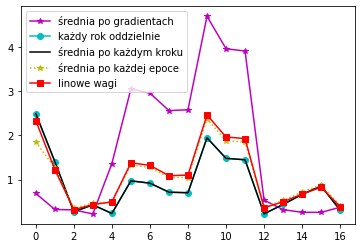

In [116]:
l_avg, o_avg = model(a_avg,X,Y)
l_all, o_all = model(a_all,X,Y)
l_step, o_step = model(a_step,X,Y)
l_nxt, o_nxt = model(a_nxt,X,Y)
l_wgth, o_wgth = model(a_wgth,X,Y)

plt.plot(l_avg,'m-*')
plt.plot(l_all,'c-o') # =='średnia po każdum kroku'
plt.plot(l_step,'k-') # =='średnia po każdum kroku'
plt.plot(l_nxt,'y:*')
plt.plot(l_wgth,'r-s')

#plt.plot([0,16],[np.mean(l_avg),np.mean(l_avg)],'m--')
#plt.plot([0,16],[np.mean(l_all),np.mean(l_all)],'c--')
#plt.plot([0,16],[np.mean(o_step),np.mean(o_step)],'k--')
#plt.plot([0,16],[np.mean(l_nxt),np.mean(l_nxt)],'y--')
#plt.plot([0,16],[np.mean(l_wgth),np.mean(l_wgth)],'r--')

plt.legend(['średnia po gradientach', 
            'każdy rok oddzielnie', 
            'średnia po każdym kroku',
            'średnia po każdej epoce', 
            'linowe wagi'
            #,'log wagi'
           ])
plt.show()

(0.0, 1.0)

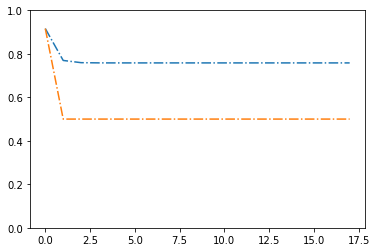

In [59]:
plt.plot(o_avg.mean(1), '-.')
plt.plot(o_all.mean(1), '-.')
plt.ylim(0,1)

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
http://proceedings.mlr.press/v57/zhao16.pdf <br>
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816 <br>
https://developer.apple.com/documentation/coreml/core_ml_api/making_predictions_with_a_sequence_of_inputs <br>
https://www.youtube.com/watch?v=WCUNPb-5EYI